In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
from astropy.visualization import AsymmetricPercentileInterval, LogStretch, MinMaxInterval


In [3]:
WORKDIR='/home/lapy/PhD/Courses/MachineLearning/Project2/'
SRC = os.path.join(WORKDIR, 'gravitational_lens_ml/src')
DATA = os.path.join(WORKDIR,'')
RESULTS = os.path.join(WORKDIR, 'gravitational_lens_ml/results')
TRAIN = os.path.join(DATA, 'datapack2.0train/')
TEST = os.path.join(DATA, 'datapack2.0test/')

In [4]:
image_catalog = pd.read_csv(os.path.join(DATA, 'datapack2.0train/image_catalog2.0train.csv'), comment='#', index_col=0)
print(image_catalog.shape)
display(image_catalog.isna().sum(axis=0))
# No effective magnification for 11182 records.

(100009, 26)


ID                  0
x_crit              0
y_crit              0
source_ID           0
z_source            0
z_lens              0
mag_source          0
ein_area            0
n_crit              0
r_source            0
crit_area           0
n_pix_source        0
source_flux         0
n_pix_lens          0
lens_flux           0
n_source_im         0
mag_eff         11182
sb_contrast         0
color_diff          0
n_gal_3             0
n_gal_5             0
n_gal_10            0
halo_mass           0
star_mass           0
mag_lens            0
n_sources           0
dtype: int64

In [5]:
image_catalog['is_lens'] = (image_catalog['mag_lens'] > 1.2) & (image_catalog['n_sources'] != 0)
print('Number of lenses: %i'%image_catalog['is_lens'].sum())

Number of lenses: 90003


In [6]:
band = 'EUC_VIS'
def get_file_id(filename, band):
    return filename.replace('image%s-'%band,'').replace('.fits', '')
file_id_train = np.array([get_file_id(f, band) for f in os.listdir(os.path.join(TRAIN, band))], dtype=int)
def check_existing_files(band, set_):
    for ID in image_catalog.ID:
        if not os.path.isfile(os.path.join(set_, band,'image%s-%i.fits'%(band, ID))):
            print('File image%s-%i.fits does not exist in set.'%(band, ID))
print(np.setdiff1d(image_catalog.ID.values, file_id_train, assume_unique=False))

[213913 226305 233597 244071 259871 261145 270458 288731 294173]


In [49]:
import aplpy 
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp
import tensorflow as tf
import tensorflow_transform as tft

In [39]:
def get_image_filename_from_id(id_, band, set_ = TRAIN):
    fname = os.path.join(set_, '{0}/image{0}-{1}.fits'.format(band, id_))
    return fname
def plot_all_bands_from_id(id_):
    fig = plt.figure(figsize=(20, 6))
    bands = ['EUC_VIS', 'EUC_H', 'EUC_Y', 'EUC_J']
    fitsfigs = []
    data = []
    for i, band in enumerate(bands):
        with fits.open(get_image_filename_from_id(id_, band)) as hdu:
            data.append(hdu[0].data)
        fitsfigs.append(aplpy.FITSFigure(data[i], figure=fig, subplot=(1,4,i+1)))
        fitsfigs[i].show_colorscale()
        fitsfigs[i].set_theme('preety')
        fitsfigs[i].set_title(band)
        fitsfigs[i].add_colorbar()
    fig.tight_layout() 


INFO: Auto-setting vmin to -3.369e-12 [aplpy.core]
INFO: Auto-setting vmax to  2.056e-11 [aplpy.core]


INFO: Auto-setting vmin to -1.236e-10 [aplpy.core]
INFO: Auto-setting vmax to  1.096e-09 [aplpy.core]


INFO: Auto-setting vmin to -8.179e-11 [aplpy.core]
INFO: Auto-setting vmax to  6.074e-10 [aplpy.core]


INFO: Auto-setting vmin to -1.043e-10 [aplpy.core]
INFO: Auto-setting vmax to  8.215e-10 [aplpy.core]


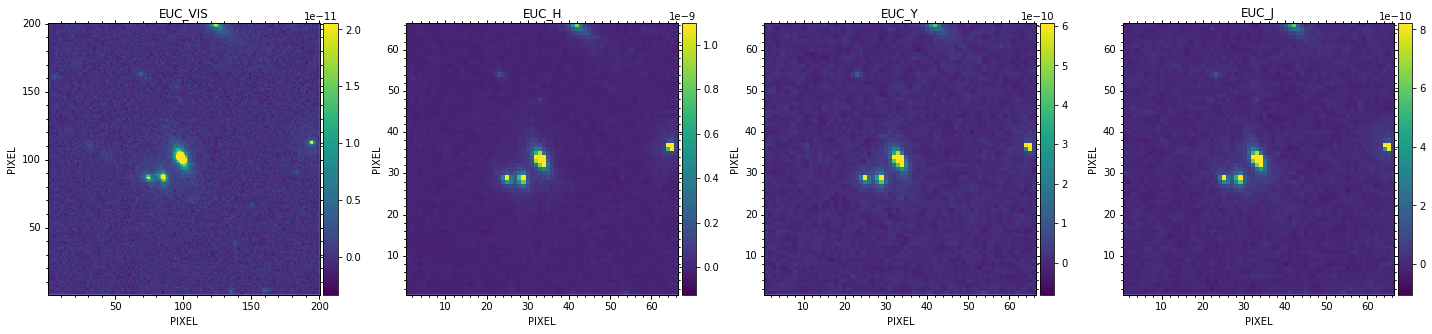

In [40]:
plot_all_bands_from_id(270610)

(200, 200)
(66, 66)
(66, 66)
(66, 66)
INFO: Auto-setting vmin to -9.851e-11 [aplpy.core]
INFO: Auto-setting vmax to  8.777e-10 [aplpy.core]


/home/lapy/Apps/anaconda3/envs/tensorflow/lib/python3.7/site-packages/reproject/interpolation/core_celestial.py:26: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(array.dtype, np.float):
/home/lapy/Apps/anaconda3/envs/tensorflow/lib/python3.7/site-packages/reproject/interpolation/core_celestial.py:26: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(array.dtype, np.float):


INFO: Auto-setting vmin to -7.366e-11 [aplpy.core]
INFO: Auto-setting vmax to  5.816e-10 [aplpy.core]


/home/lapy/Apps/anaconda3/envs/tensorflow/lib/python3.7/site-packages/reproject/interpolation/core_celestial.py:26: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(array.dtype, np.float):


INFO: Auto-setting vmin to -9.304e-11 [aplpy.core]
INFO: Auto-setting vmax to  7.632e-10 [aplpy.core]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 5.79663446e-12
 5.79665482e-12 5.79665482e-12]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.71465212e-12
 4.71466095e-12 4.71466095e-12]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 7.16754381e-12
 7.16756559e-12 7.16756559e-12]


RuntimeError: tf.placeholder() is not compatible with eager execution.

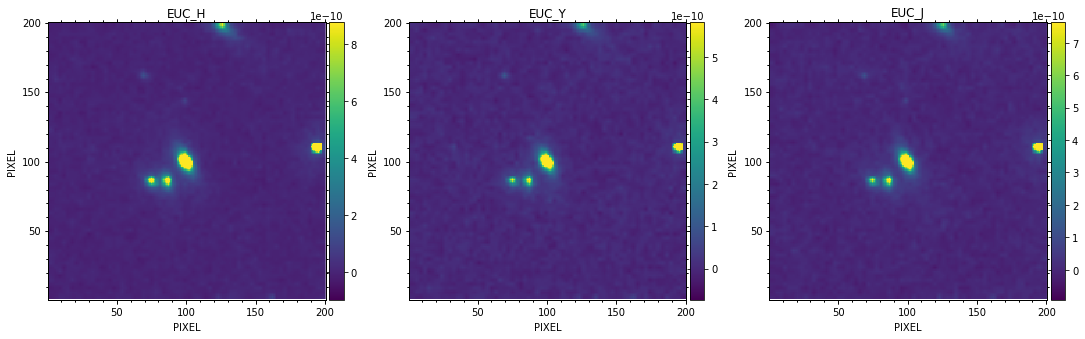

In [76]:
bands = ['EUC_VIS', 'EUC_H', 'EUC_Y', 'EUC_J']
bands_NIR = ['EUC_H', 'EUC_Y', 'EUC_J']
myid = 270610
data_NIR_reprojected = [] 
data_flatten = []
fitsfigs = []
fig = plt.figure(figsize=(20, 6))

for i, band in enumerate(bands):
    with fits.open(get_image_filename_from_id(myid, band)) as hdu:
        print(hdu[0].shape)
        
with fits.open(get_image_filename_from_id(myid, 'EUC_VIS')) as hdu1:    
    data1 = hdu1[0].data

for i, band in enumerate(bands_NIR):        
    with fits.open(get_image_filename_from_id(myid, band)) as hdu2:
        data2 = hdu2[0].data
        data2_reprojected, data2_footprint = reproject_interp(hdu2[0], hdu1[0].header)
        data_NIR_reprojected.append(data2_reprojected)
            
    fitsfigs.append(aplpy.FITSFigure(data_NIR_reprojected[i], figure=fig, subplot=(1,4,i+1)))
    fitsfigs[i].show_colorscale()
    fitsfigs[i].set_theme('preety')
    fitsfigs[i].set_title(band)
    fitsfigs[i].add_colorbar()
        
fig.tight_layout()         
                

for i, data_NIR in enumerate(data_NIR_reprojected):
    data_NIR[np.isnan(data_NIR)] = 0
    data_flatten.append(data_NIR.flatten())
    print(data_flatten[i])
    

mytensor = tf.convert_to_tensor(data_flatten)
tmp = tft.pca(mytensor, 3, tf.float64)

/home/lapy/Apps/anaconda3/envs/tensorflow/lib/python3.7/site-packages/reproject/interpolation/core_celestial.py:26: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(array.dtype, np.float):


In [27]:
#for i, hdudata in enumerate(data2_reprojected):
print(data2_reprojected.shape)

(200, 200)
